In [1]:
import warnings
import time
import pandas as pd
from tqdm import tqdm

from helpers import classification as pf
from helpers import stats as bf
from helpers.file import save_file
from helpers.simulation_logger import SimulationLogger
from helpers.model_config import custom_models_config

warnings.filterwarnings("ignore")

start_time = time.time()

Setup Complete


In [2]:
league = "spain-laliga"
start_season = 2012
save_pipeline = False
random_state = 0

min_games_played = 10
min_games_played_at = 5

betting_starts_after_n_games = 0

filtered_cols = [
    'home_points_pct', 
    'home_win_pct', 'home_draw_pct', 'home_loss_pct',
    'home_points_pct_last_games',
    # 'home_win_pct_last_games', 'home_draw_pct_last_games', 'home_loss_pct_last_games',
    'home_home_win_pct', 'home_home_draw_pct', 'home_home_loss_pct',
    'home_team_xg', 'home_opp_xg',
    'home_team_score', 'home_opp_score',
    'home_home_team_xg', 'home_home_opp_xg',
    'home_home_team_score', 'home_home_opp_score',
    'away_points_pct', 
    'away_win_pct', 'away_draw_pct', 'away_loss_pct',
    'away_points_pct_last_games',
    # 'away_win_pct_last_games', 'away_draw_pct_last_games', 'away_loss_pct_last_games',
    'away_away_win_pct', 'away_away_draw_pct', 'away_away_loss_pct',
    'away_team_xg', 'away_opp_xg',
    'away_team_score', 'away_opp_score',
    'away_away_opp_xg', 'away_away_team_xg',
    'away_away_opp_score', 'away_away_team_score', 
    'home_elo', 'away_elo'
]

filtered_cols.extend([
    'home_odds', 'away_odds', 'draw_odds',
    "home_ahc_odds",
    "ahc_line",
    "away_ahc_odds",
    "overs_odds",
    "totals_line",
    "unders_odds",
])

markets = {
    "result": [["H", "D", "A"], 2.2],
    "ahc_result": [["H", "A", "P"], 1.6],
    "totals_result": [["O", "U", "P"], 1.6]
}

fast_simulation = True
preprocess = False
min_odds = 2.2
bankroll = 900
strategy = "default"
default_value = 1
default_bankroll_pct = 0.05

plot_threshold = 0

In [3]:
# Initialize logger
logger = SimulationLogger(league)

# Log all configuration parameters
logger.log_config(
    league=league,
    start_season=start_season,
    save_pipeline=save_pipeline,
    random_state=random_state,
    min_games_played=min_games_played,
    min_games_played_at=min_games_played_at,
    betting_starts_after_n_games=betting_starts_after_n_games,
    filtered_cols=filtered_cols,
    markets=markets,
    fast_simulation=fast_simulation,
    preprocess=preprocess,
    min_odds=min_odds,
    bankroll=bankroll,
    strategy=strategy,
    default_value=default_value,
    default_bankroll_pct=default_bankroll_pct,
    plot_threshold=plot_threshold,
    custom_models_config=custom_models_config if 'custom_models_config' in globals() else None
)

📁 Simulation directory created: ../dist/simulations\spain-laliga\2025-08-26_21-04-16


In [4]:
matches, _ = bf.initialize_matches(league, start_season)
display(matches)

Generating teams ELOs...


100%|██████████| 4940/4940 [00:00<00:00, 7176.50it/s]

Successfully generated teams ELOs.


,season,date,week,home_team,home_xg,home_score,away_score,away_xg,away_team,league,...,ahc_line,away_ahc_odds,overs_odds,totals_line,unders_odds,result,ahc_result,totals_result,home_elo,away_elo
0,2012,2012-08-18,1,Celta Vigo,NaN,0,1,NaN,Málaga,spain-laliga,...,0.25,1.80,2.02,2.50,1.88,A,A,U,1500.00,1500.00
1,2012,2012-08-18,1,Mallorca,NaN,2,1,NaN,Espanyol,spain-laliga,...,0.50,1.82,1.97,2.25,1.93,H,H,O,1500.00,1500.00
2,2012,2012-08-18,1,Sevilla,NaN,2,1,NaN,Getafe,spain-laliga,...,0.75,2.00,2.02,2.50,1.88,H,H,O,1500.00,1500.00
3,2012,2012-08-19,1,Athletic Club,NaN,3,5,NaN,Betis,spain-laliga,...,0.75,1.80,1.97,2.50,1.93,A,A,O,1500.00,1500.00
4,2012,2012-08-19,1,Barcelona,NaN,5,1,NaN,Real Sociedad,spain-laliga,...,2.75,1.95,2.05,3.75,1.85,H,H,O,1500.00,1500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,2024,2025-05-24,38,Rayo Vallecano,2.2,0,0,0.6,Mallorca,spain-laliga,...,0.75,2.10,1.80,2.00,2.05,D,A,U,1517.41,1490.94
4936,2024,2025-05-24,38,Real Madrid,2.6,2,0,0.8,Real Sociedad,spain-laliga,...,1.25,1.98,1.80,3.00,2.05,H,H,U,1807.22,1526.85
4937,2024,2025-05-25,38,Athletic Club,1.2,0,3,3.5,Barcelona,spain-laliga,...,-0.25,1.98,1.98,3.00,1.88,A,A,P,1689.06,1819.68
4938,2024,2025-05-25,38,Girona,0.0,0,4,2.7,Atlético Madrid,spain-laliga,...,-0.50,1.98,1.98,3.00,1.88,A,A,O,1518.76,1711.87


In [5]:
data_model = []

for index, game in tqdm(matches.iterrows(), total=len(matches)):
    if pd.isnull(game["home_odds"]):
        continue

    home_stats_dict = bf.get_team_previous_games_stats(
        game["home_team"], game["season"], game["date"], "H", min_games_played, min_games_played_at, matches
    )
    if not home_stats_dict:
        continue

    away_stats_dict = bf.get_team_previous_games_stats(
        game["away_team"], game["season"], game["date"], "A", min_games_played, min_games_played_at, matches
    )
    if not away_stats_dict:
        continue

    game_info_keys = [
        "date",
        "season",
        "home_team",
        "away_team",
        "home_odds",
        "away_odds",
        "draw_odds",
        "result",
        "ahc_result",
        "totals_result",
        "home_score",
        "away_score",
        "home_elo",
        "away_elo",
        "home_ahc_odds",
        "ahc_line",
        "away_ahc_odds",
        "overs_odds",
        "totals_line",
        "unders_odds",
    ]
    game_info_dict = {key: game[key] for key in game_info_keys}

    data_model.append({**home_stats_dict, **away_stats_dict, **game_info_dict})

data_df = pd.DataFrame(data_model)

100%|██████████| 4940/4940 [01:51<00:00, 44.48it/s] 


In [6]:
display(data_df)

,home_points_pct,home_win_pct,home_draw_pct,home_loss_pct,home_points_pct_last_games,home_win_pct_last_games,home_draw_pct_last_games,home_loss_pct_last_games,home_home_win_pct,home_home_draw_pct,...,home_score,away_score,home_elo,away_elo,home_ahc_odds,ahc_line,away_ahc_odds,overs_odds,totals_line,unders_odds
0,0.633333,0.600000,0.100000,0.300000,0.633333,0.6,0.1,0.3,0.600000,0.000000,...,1,2,1527.22,1451.53,2.15,0.75,1.78,1.97,2.50,1.93
1,0.300000,0.200000,0.300000,0.500000,0.300000,0.2,0.3,0.5,0.200000,0.400000,...,0,3,1479.30,1445.86,1.80,0.25,2.10,2.07,2.50,1.82
2,0.600000,0.500000,0.300000,0.200000,0.600000,0.5,0.3,0.2,0.600000,0.200000,...,1,2,1534.66,1467.45,1.85,1.00,2.05,2.02,2.75,1.88
3,0.433333,0.400000,0.100000,0.500000,0.433333,0.4,0.1,0.5,0.400000,0.200000,...,3,2,1468.69,1475.38,2.07,0.25,1.82,1.82,2.50,2.07
4,0.400000,0.400000,0.000000,0.600000,0.400000,0.4,0.0,0.6,0.400000,0.000000,...,5,3,1471.72,1472.98,2.07,0.50,1.82,1.90,2.25,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,0.459459,0.351351,0.324324,0.324324,0.500000,0.4,0.3,0.3,0.333333,0.388889,...,0,0,1517.41,1490.94,1.78,0.75,2.10,1.80,2.00,2.05
3581,0.729730,0.675676,0.162162,0.162162,0.800000,0.8,0.0,0.2,0.833333,0.055556,...,2,0,1807.22,1526.85,1.88,1.25,1.98,1.80,3.00,2.05
3582,0.630631,0.513514,0.351351,0.135135,0.633333,0.5,0.4,0.1,0.611111,0.333333,...,0,3,1689.06,1819.68,1.88,-0.25,1.98,1.98,3.00,1.88
3583,0.369369,0.297297,0.216216,0.486486,0.266667,0.2,0.2,0.6,0.388889,0.166667,...,0,4,1518.76,1711.87,1.88,-0.50,1.98,1.98,3.00,1.88


In [7]:
last_season = matches.iloc[-1]["season"]

# Prepare a list of function calls for each season
function_calls = []

for season in range(start_season + 1, last_season + 1):
    for result_col, market_values in markets.items():
        class_order, _ = market_values

        matches_filtered = pf.get_filtered_matches(
            data_df,
            filtered_cols,
            start_season,
            season
        )

        if not len(matches_filtered[matches_filtered["season"] < season]):
            continue

        # Store a tuple with season, result_col, and a lambda function
        function_calls.append((
            season,
            result_col,
            lambda season=season, result_col=result_col, class_order=class_order: pf.simulate_with_classification(
                data_df,
                start_season,
                season,
                filtered_cols,
                random_state=random_state,
                preprocess=preprocess,
                result_col=result_col,
                class_order=class_order,
                fast_simulation=fast_simulation,
                custom_models_config=custom_models_config,
            )
        ))

# Train and evaluate model
print("Training and evaluating models throughout the seasons...")
last_season_models = {}

# Initialize matches outside the loop
matches = data_df.copy()

for season, result_col, func in tqdm(function_calls):
    season_matches, trained_models = func()
    
    # Update the main matches dataframe with new values
    for col in season_matches.columns:
        # Only update rows that exist in matches
        matches.loc[season_matches.index, col] = season_matches[col]

    if season == last_season:
        last_season_models[result_col] = trained_models

Training and evaluating models throughout the seasons...


100%|██████████| 21/21 [01:44<00:00,  4.96s/it]


In [8]:
# Replace the model accuracy cell with:

models = pf.get_classification_models()

def show_all_accuracies():
    print("1x2 Model Accuracies:")
    pf.show_classification_accuracies(matches, models, result_col="result")
    
    print("\nAHC Model Accuracies:")
    pf.show_classification_accuracies(matches, models, result_col="ahc_result")
    
    print("\nTotals Models Accuracies:")
    pf.show_classification_accuracies(matches, models, result_col="totals_result")

# Capture and save the accuracy outputs
logger.capture_print(show_all_accuracies, "Model Accuracies Comparison")

# Also save to dedicated file
logger.save_model_accuracies(matches, models, markets)

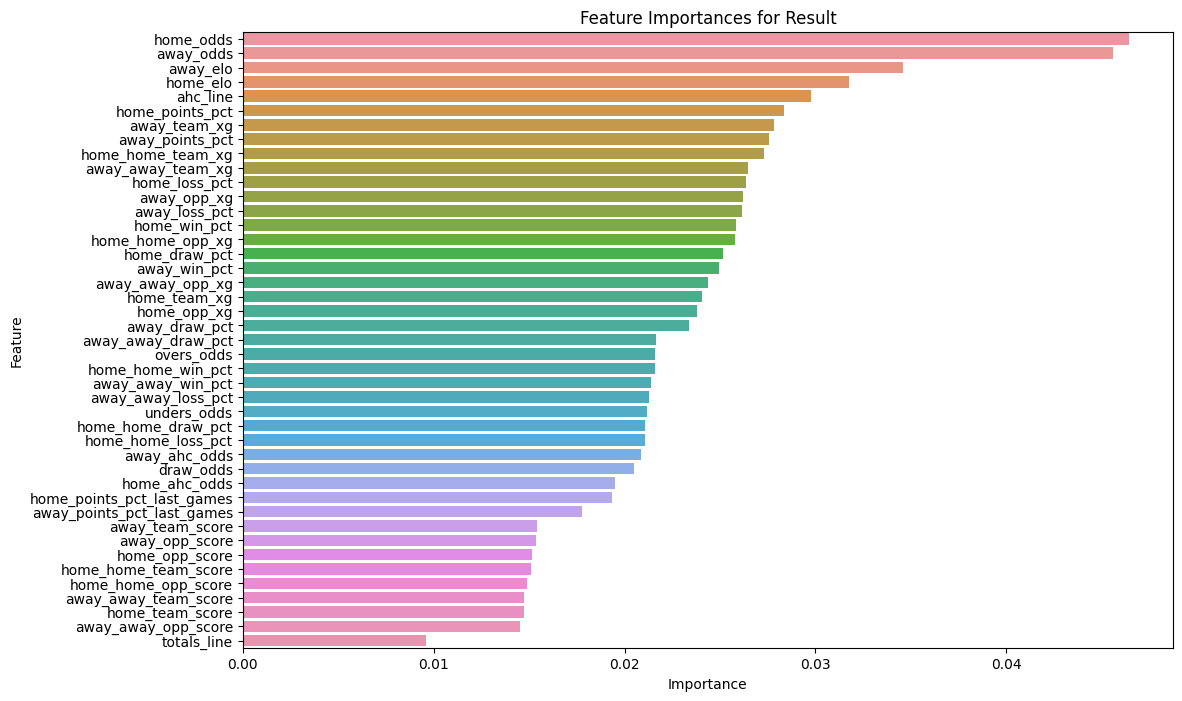

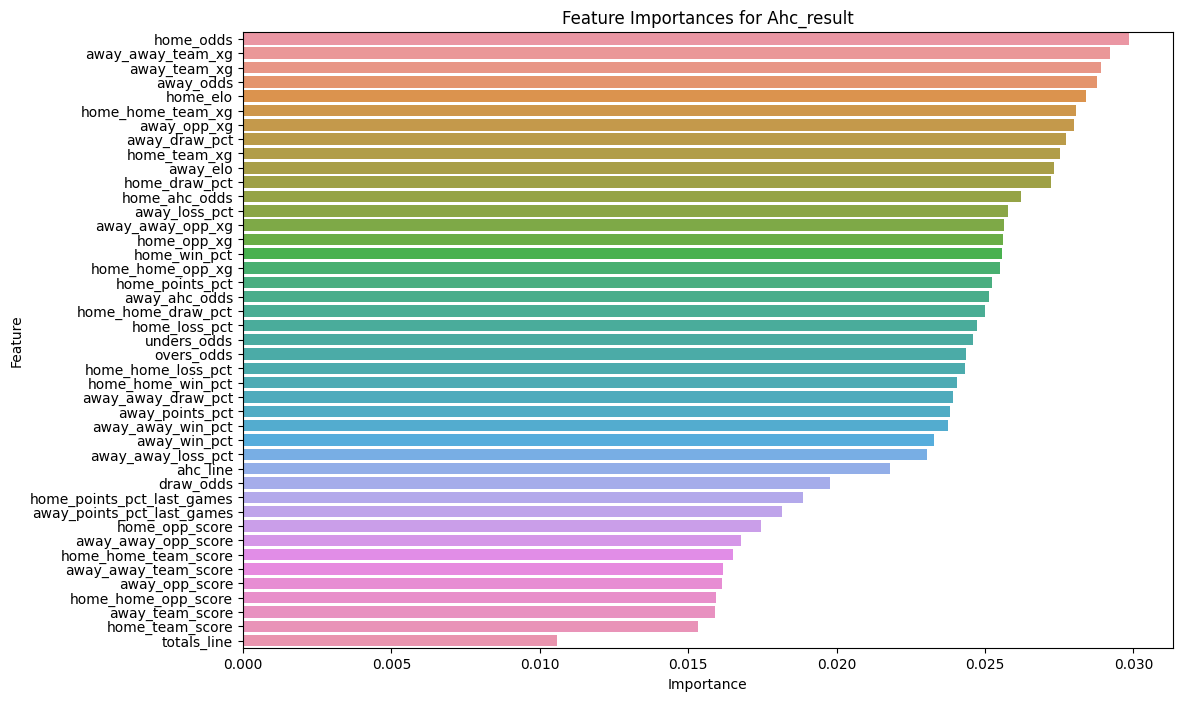

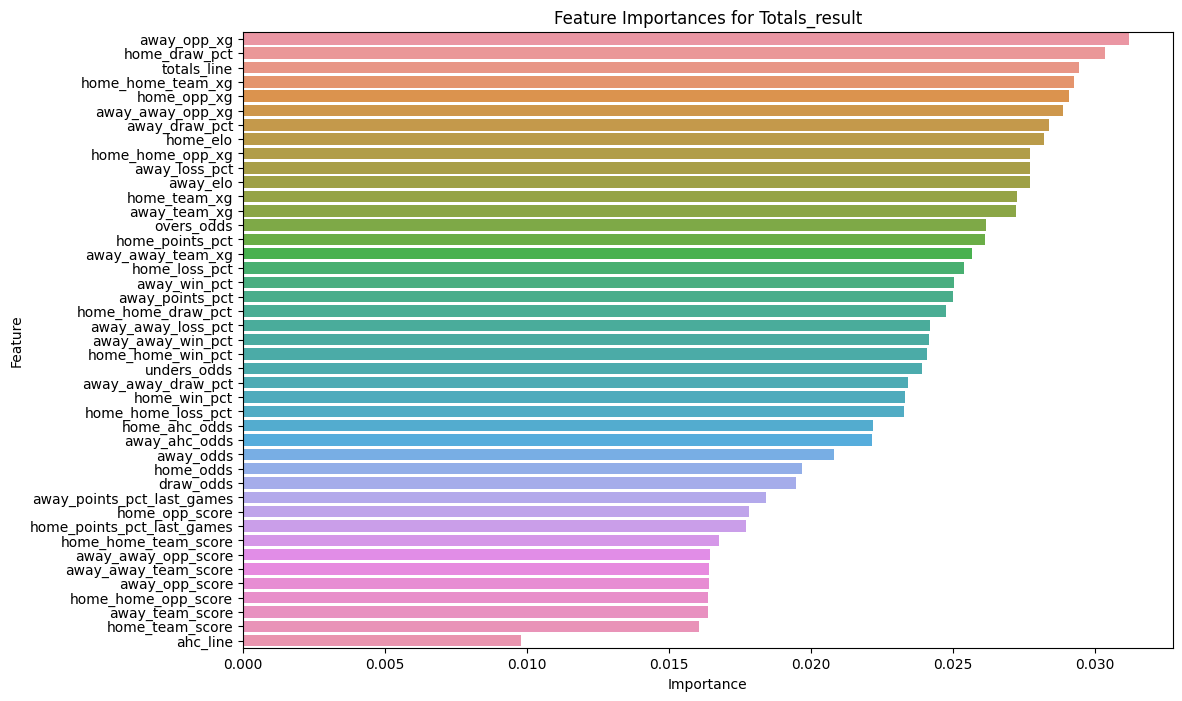

In [9]:
# Replace feature importance cell with:

def show_feature_importances():
    return pf.display_random_forest_feature_importances(last_season_models, filtered_cols, logger=logger)

# Capture output and save ALL charts
logger.capture_print(show_feature_importances, "Random Forest Feature Importances")

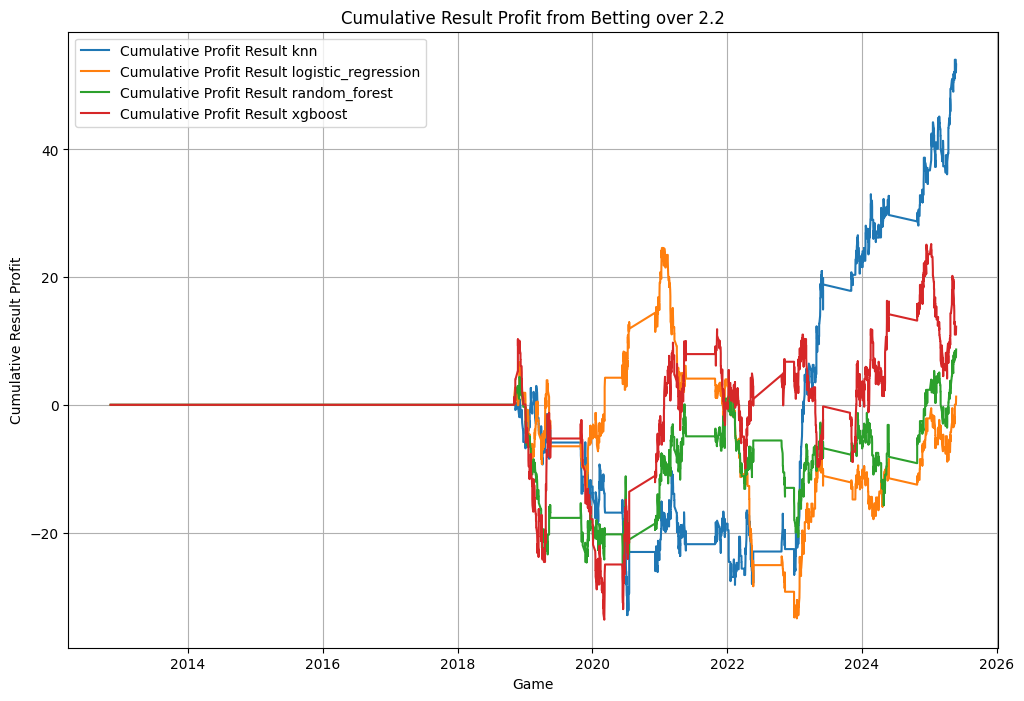

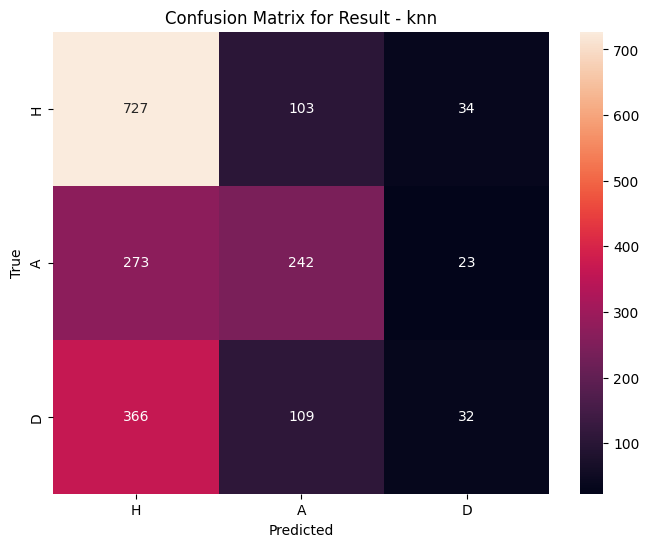

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


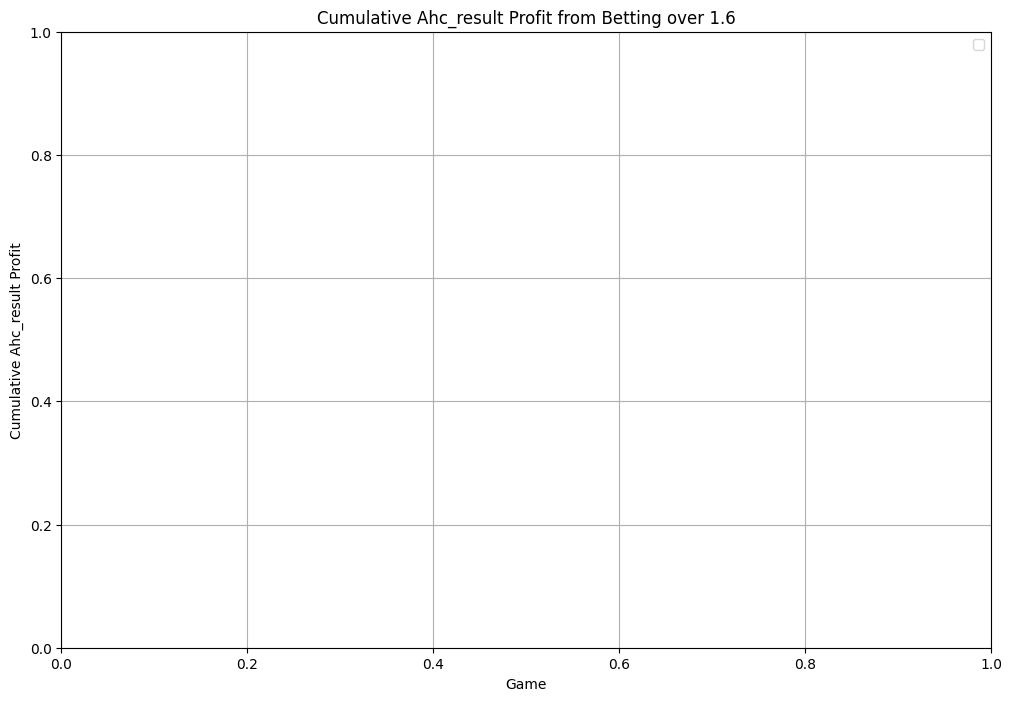

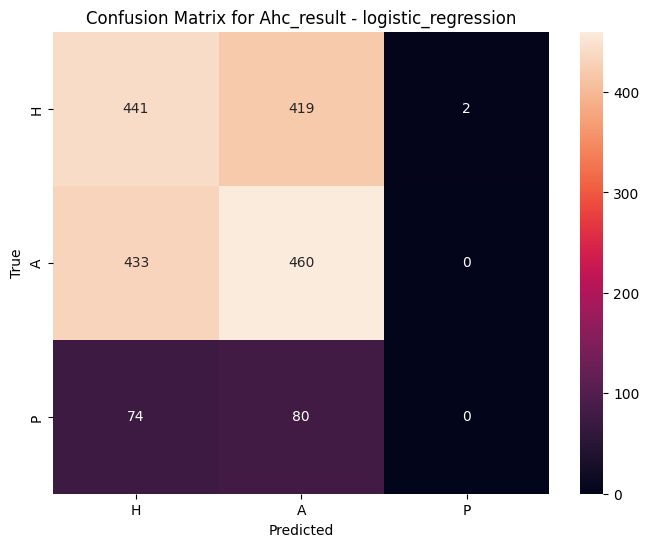

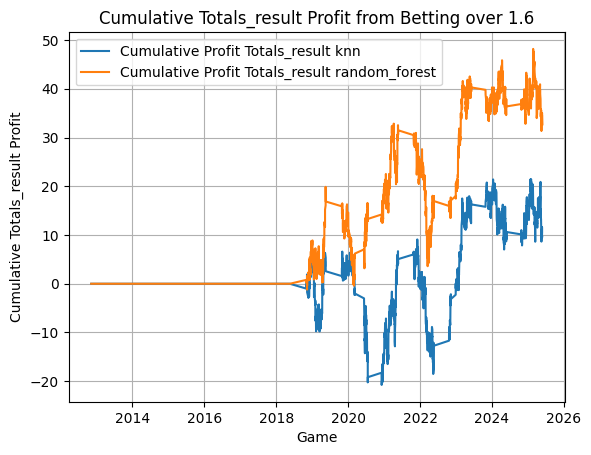

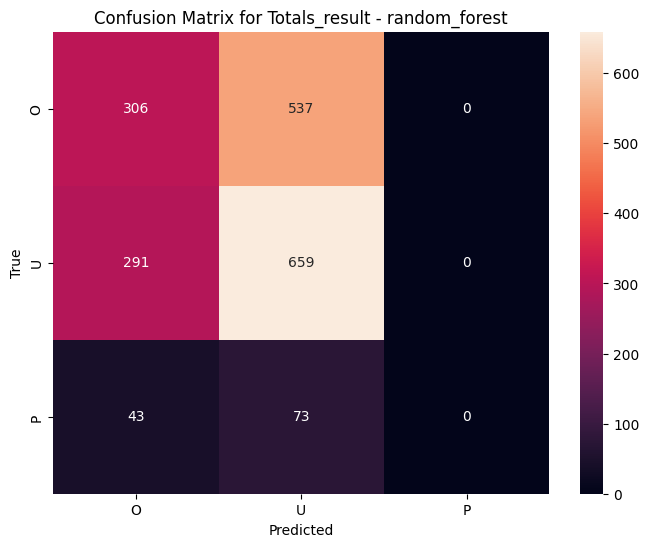

In [10]:
# Replace the profit analysis cell with:

min_odds_1x2 = markets["result"][1]
min_odds_ahc = markets["ahc_result"][1]
min_odds_totals = markets["totals_result"][1]

def run_profit_analysis():
    return pf.get_classification_simulation_results(
        matches,
        start_season,
        plot_threshold,
        bankroll,
        strategy,
        default_value,
        default_bankroll_pct,
        min_odds_1x2,
        min_odds_ahc,
        min_odds_totals,
        logger=logger,
    )

# Capture profit analysis
best_models = logger.capture_print(run_profit_analysis, "Profit Analysis and Model Performance")
best_1x2_model, best_ahc_model, best_totals_model = best_models

In [11]:
# Save detailed model parameters
logger.save_model_parameters(last_season_models, markets)

# Capture the model parameters output as well
def show_model_params():
    for market_name, models in last_season_models.items():
        print(f"\n{'='*50}")
        print(f"MARKET: {market_name.upper()}")
        print(f"{'='*50}")
        
        for model_name, model_info in models.items():
            print(f"\nModel: {model_info['estimator'].__class__.__name__}")
            print(f"Model Key: {model_name}")
            print(f"Score: {model_info.get('score')}")
            print(f"Parameters: {model_info.get('params')}")
            
            if "pipeline" in model_info:
                pipeline_steps = list(model_info["pipeline"].named_steps.keys())
                print(f"Pipeline Steps: {pipeline_steps}")
                
                # Show model step parameters
                model_step = model_info["pipeline"].named_steps.get("model")
                if model_step:
                    print(f"Model Step Parameters: {model_step.get_params()}")
            print("-" * 40)

# Capture model parameters output
logger.capture_print(show_model_params, "Detailed Model Parameters for All Markets")

🔧 Model parameters saved: model_parameters.json


In [12]:
# Create simulation summary
simulation_summary = {
    "simulation_info": {
        "league": league,
        "start_season": start_season,
        "end_season": matches['season'].max(),
        "total_matches": len(matches),
        "total_function_calls": len(function_calls),
        "execution_time": "N/A"  # You could add timing
    },
    "best_models": {
        "result": best_1x2_model,
        "ahc_result": best_ahc_model, 
        "totals_result": best_totals_model
    },
    "final_bankroll": {
        "result": matches[f'CumulativeProfitML_{best_1x2_model}'].iloc[-1] if f'CumulativeProfitML_{best_1x2_model}' in matches.columns else None,
        "ahc_result": matches[f'CumulativeProfitML_{best_ahc_model}'].iloc[-1] if f'CumulativeProfitML_{best_ahc_model}' in matches.columns else None,
        "totals_result": matches[f'CumulativeProfitML_{best_totals_model}'].iloc[-1] if f'CumulativeProfitML_{best_totals_model}' in matches.columns else None,
    },
    "model_performance": {
        model_name: {
            "accuracy": models[model_name].get("score"),
            "params": models[model_name].get("params")
        } for model_name in models.keys()
    },
    "last_season_models_summary": {
        market: {
            model_name: {
                "estimator": model_info["estimator"].__class__.__name__,
                "score": model_info.get("score"),
                "params": model_info.get("params")
            }
            for model_name, model_info in market_models.items()
        }
        for market, market_models in last_season_models.items()
    }
}

execution_time = time.time() - start_time
simulation_summary["simulation_info"]["execution_time"] = f"{execution_time:.2f} seconds"

# Finalize logging
logger.finalize(simulation_summary)

print(f"\n🎉 Simulation complete! All results saved to:")
print(f"📁 {logger.simulation_dir}")

✅ Simulation logged to: ../dist/simulations\spain-laliga\2025-08-26_21-04-16

🎉 Simulation complete! All results saved to:
📁 ../dist/simulations\spain-laliga\2025-08-26_21-04-16


In [14]:
matches_filtered = matches[["date",  "season", "home_team", "away_team", "home_score", "away_score", "result", "home_odds", "draw_odds", "away_odds", f"PredictedRes_{best_model_name}", f'ProfitML_{best_model_name}', f'CumulativeProfitML_{best_model_name}']]
matches_filtered = matches_filtered[matches_filtered["season"] == 2024]
matches_filtered.tail(5)

# matches_filtered.to_csv("analysis_predictor.csv")

NameError: name 'best_model_name' is not defined

In [ ]:
my_pipeline = trained_models[best_model_name]["pipeline"]
my_pipeline

data = {
    "pipeline": my_pipeline,
    "best_model_name": best_model_name,
    "min_games_played": min_games_played,
    "min_games_played_at": min_games_played_at,
    "min_odds": min_odds,
    "filtered_cols": filtered_cols,
    "strategy": strategy,
    "default_value": default_value,
    "default_bankroll_pct": default_bankroll_pct
}

# Save the pipeline
if save_pipeline:
    path = f"../dist/betting"
    
    save_file(path, data, league)

: 